<a href="https://colab.research.google.com/github/sm0904/Machine-Learning/blob/master/FTSMA_CPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import math
import sys
import os
from IPython.display import display
from collections import defaultdict

**Checkpoints indicate the blocks of data correpsonding to different months**

In [ ]:
checkpoints = [[0, 31], [31, 61], [61, 92], [92, 122], [122, 153], [153, 184], [184, 214], [214, 245], [245, 275], [275, 306], [306, 337], [337, 365], [365, 396], [396, 426], [426, 457], [457, 487], [487, 518], [518, 549], [549, 579], [579, 610]]


**Implementation of the FTS class, all functionalities are encapsulated into this class**

In [ ]:
class FTS:
  def __init__ (self , n , data):
    self.data = data
    self.n = n
    self.growths = [0] * (n - 1)
    self.genGrowths()
    self.intervals = []
    self.epsilon = 0.25
    self.count = defaultdict(list)
    self.forecasts = []
    self.count_pairs = []
    self.defuzzified_values = []
    self.FLRGS = defaultdict(list)
    self.midpoints = []
    self.markov = defaultdict(defaultdict)
    self.genIntervals(7)
    self.classLabels = [-1] * n
    self.populateCount()
    self.assignClass()
    self.subPartition()
    self.forecast()
  
  def reset(self):
    self.count = defaultdict(list)
    self.classLabels = [-1] * self.n
    self.markov = defaultdict(defaultdict)
    self.FLRGS = defaultdict(list)


  def genGrowths(self):
    self.growths = [round((self.data[i] - self.data[i - 1]) / self.data[i - 1] * 100 , 6) for i in range(1 , self.n)]

  def MSE(self,forecast):
    return np.sum([(x - y) ** 2 for x , y in zip(self.data , [x for x in forecast])]) * 1 / self.n

  def RMSE(self,forecast):
    return math.sqrt(self.MSE(forecast))

  def AFER(self,forecast):
    return np.sum([abs(x - y)  / x for x , y in zip(self.data , [x for x in forecast])]) * 1 / self.n * 100

  def Theil(self , forecast):
    return np.sum([(x - y) ** 2 for x , y in zip(data , [x for x in forecast])]) / (np.sum([x * x for x in data]) + np.sum(x * x for x in forecast))

  def forecast(self):
    self.forecasts = [self.predict(i) for i in range(0 , len(self.data))]

  def fuzzify(self):
    fuzzified = {'ACTUAL DATA': [] , 'FUZZIFIED VALUE': [] , 'GROWTH' : [] , 'FLR' : []}
    fuzzified['ACTUAL DATA'] = self.data
    fuzzified['FUZZIFIED VALUE'] = ['A{}'.format(self.belongs(self.growths[i - 1]) + 1) if i > 0 else '-' for i in range(self.n)]
    fuzzified['FLR'] = ['A{a} -> A{b}'.format(a = self.belongs(self.growths[i - 2]) + 1 , b = self.belongs(self.growths[i - 1]) + 1) if i > 1 else '-' for i in range(self.n)]
    fuzzified['GROWTH'] = ['{}'.format(self.growths[i - 1]) if i > 0 else  '-' for i in range(self.n)]
    fuzzify_df = pd.DataFrame(fuzzified)
    fuzzify_df = fuzzify_df[['ACTUAL DATA' , 'GROWTH' , 'FUZZIFIED VALUE' , 'FLR']]
    return fuzzify_df

  def compareResults(self):
    comparison = {'DATE' : [] , 'ACTUAL DATA' : [] , 'FORECAST' : [] , 'ABSOLUTE ERROR' : []}
    comparison['DATE'] = [x + 1 for x in range(len(self.data))]
    comparison['ACTUAL DATA'] = self.data
    comparison['FORECAST'] = self.forecasts
    comparison['ABSOLUTE ERROR'] = [abs(self.data[i] - self.forecasts[i]) for i in range(len(self.data))]
    compare_result_df = pd.DataFrame(comparison)
    return compare_result_df


  def intervaldisplay(self):
    self.intervals.sort()
    intervals = {'Interval number' : [] , 'Interval range' : [] , 'Midpoints' : [] , 'Linguistic variable' : []}
    intervals['Interval number'] = np.arange(1 , len(self.intervals) + 1)
    intervals['Interval range'] = [[round(x , 2) for x in self.intervals[i]] for i in range(len(self.intervals))]
    intervals['Midpoints'] = [round((u + v) / 2 , 2) for u , v in self.intervals]
    intervals['Linguistic variable'] = ['A{}'.format(i) for i in range(1 , len(self.intervals) + 1)]
    interval_df = pd.DataFrame(intervals)
    return interval_df

  
  def defuzzify(self , index , midpoints):
    return self.weightedAverage(self.markov[index], index)
  
  def inside(self,  x , l , r):
    return x >= l and x <= r

  def belongs(self , x):
    for i in range(len(self.intervals)):
      if(self.inside(x , self.intervals[i][0] , self.intervals[i][1])):
        return i
    return -1

  def genIntervals(self , m):
    L , R = min(self.growths) , max(self.growths)
    interval_length = (R - L) / m
    intervals = []
    l = L
    for i in range(m):
      r = l + interval_length
      intervals.append([l , r])
      l = r
    
    self.intervals = [[round(x[0] , 7) , round(x[1] , 7)] for x in intervals]

  def subdivide(self , interval):
    L , R = interval[0] , interval[1]
    return [[L , L + (R - L) / 2] , [L + (R - L) / 2 , R]]
    
  def populateCount(self):
    for i in range(len(self.growths)):
      self.count[self.belongs(self.growths[i])].append(self.growths[i])

  def assignClass(self):
    self.classLabels = [self.belongs(self.growths[i - 1]) + 1 if i > 0 else 0 for i in range(0 , len(data))]

  def createFLRs(self):
    for i in range(2 , len(self.classLabels)):
      self.FLRGS[self.classLabels[i - 1] - 1].append(self.classLabels[i] - 1)

  def weightedAverage(self , markov_list, index):
    if len(markov_list) == 0:
      return self.midpoints[index - 1]
    coefficients = markov_list.values()
    values = [self.midpoints[a] for a in markov_list.keys()]
    return np.sum([x * y for x , y in zip(coefficients, values)])

  def markovProcessing(self):
    self.createFLRs()
    for x ,y in self.FLRGS.items():
      currentMarkov = defaultdict(int)
      for groups in y:
        currentMarkov[groups] += 1 / len(y)
      self.markov[x] = currentMarkov   

  def counter(self , interval):
    L , R = interval[0] , interval[1]
    return np.sum([self.inside(self.growths[i] , L , R) for i in range(len(self.growths))])

  def subPartition(self):   
    intervals = [[x , self.counter(x)]  for x in self.intervals]
    iadp = np.sum([x[1] for x  in intervals]) / len(self.intervals)

    iter = 0
    while True:
      intervals = [[x , self.counter(x)]  for x in self.intervals]
      terminate = True
      for i in range(len(intervals)):
        if intervals[i][1] > iadp:
          terminate = False
          self.intervals.append(self.subdivide(intervals[i][0])[0])
          self.intervals.append(self.subdivide(intervals[i][0])[1])
          self.intervals.remove(intervals[i][0])

      if terminate is True :
        break
      iter += 1

    midpoints = [(u + v) / 2 for u , v in self.intervals]
    self.midpoints = midpoints
    
    self.reset()
    self.assignClass()
    self.markovProcessing()
  
    self.defuzzified_values = [self.defuzzify(i , midpoints) for i in range(len(self.intervals))]

  def predict(self, index):
    return int(round((self.defuzzified_values[self.belongs(self.growths[index - 1])]/ 100 + 1) * self.data[index - 1] , 0))  if index > 0 else self.data[index]
    

**Forecasts as obtained for other methods in different modules**

In [ ]:
FTSMA_GK = [3, 18, 18, 18, 18, 18, 18, 18, 18, 83, 83, 83, 83, 83, 83, 155, 155, 155, 227, 227, 328, 409, 491, 577, 667, 758, 876, 1022, 1181, 1352, 1635, 2059, 2435, 3030, 3624, 4219, 4814, 5408, 7943, 8488, 8488, 8488, 8488, 8488, 11642, 12616, 13590, 14564, 15684, 16950, 18216, 19482, 20979, 22706, 24433, 26169, 27914, 29659, 31413, 33175, 34937, 37262, 39687, 43424, 47161, 50899, 54374, 57586, 60799, 64012, 67224, 70437, 74143, 78343, 82542, 86742, 90941, 95976, 101847, 107718, 113589, 119677, 125982, 132288, 138593, 145067, 151712, 158356, 165000, 172914, 182098, 191281, 198372, 206524, 217594, 228664, 239734, 250009, 259489, 268969, 278449, 287928, 297408, 307880, 319345, 330810, 342275, 353740, 366682, 381102, 395522, 409942, 424720, 439855, 454990, 470124, 487794, 507999, 528203, 548182, 567937, 587692, 605224, 621427, 644911, 668396, 691880, 715364, 741741, 771011, 800280, 829550, 858819, 953831, 973300, 973300, 973300, 973300, 973300, 1085105, 1119037, 1152968, 1186899, 1232733, 1290470, 1348206, 1399137, 1443263, 1487388, 1531514, 1582939, 1641664, 1700390, 1752185, 1794213, 1852770, 1911328, 1969885, 2027720, 2084833, 2141946, 2199058, 2256171, 2319392, 2388721, 2458051, 2527380, 2590914, 2648654, 2706394, 2764134, 2821873, 2887041, 2959636, 3032231, 3104826, 3177802, 3251158, 3324513, 3397869, 3472946, 3549743, 3626540, 3703337, 3766121, 3840769, 3930520, 4020272, 4110859, 4202282, 4293706, 4385129, 4477494, 4570800, 4664106, 4757412, 4853377, 4952001, 5050625, 5149249, 5238095, 5317162, 5396229, 5475296, 5554363, 5641570, 5736918, 5832266, 5927614, 6013992, 6091400, 6168808, 6246216, 6323624, 6392060, 6456026, 6528904, 6601782, 6674950, 6748409, 6821868, 6895327, 6966961, 7036768, 7106576, 7176384, 7243991, 7309398, 7374804, 7440211, 7499297, 7552061, 7604826, 7657590, 7710355, 7761763, 7811816, 7861869, 7911921, 7961974, 8010384, 8057150, 8103917, 8150684, 8197451, 8229245, 8264083, 8311843, 8359604, 8406726, 8453210, 8499693, 8546177, 8592310, 8638091, 8683873, 8729654, 8770925, 8807686, 8844446, 8881207, 8917967, 8959029, 9004391, 9049754, 9095116, 9141209, 9188032, 9234854, 9281677, 9324474, 9363246, 9402018, 9440790, 9479561, 9499652, 9527414, 9562192, 9596971, 9630833, 9663779, 9696726, 9729672, 9761381, 9791851, 9822320, 9852790, 9879927, 9903731, 9927535, 9951339, 9975143, 10043738, 10057624, 10057624, 10057624, 10057624, 10057624, 10138631, 10164097, 10189564, 10211866, 10231006, 10250145, 10269284, 10288423, 10306393, 10322749, 10341260, 10359772, 10378185, 10396500, 10414815, 10433130, 10449631, 10464318, 10479005, 10493692, 10508379, 10550232, 10558706, 10558706, 10558706, 10558706, 10558706, 10608319, 10624037, 10639754, 10653803, 10666182, 10678562, 10690942, 10703322, 10717225, 10732651, 10748078, 10763504, 10767130, 10777898, 10791120, 10804342, 10816051, 10826246, 10836442, 10846637, 10856833, 10868149, 10880586, 10893023, 10905460, 10917115, 10927990, 10938864, 10949739, 10960614, 10972859, 10986475, 11000091, 11013708, 11028963, 11045857, 11062751, 11079656, 11096573, 11113490, 11124248, 11135057, 11153576, 11172095, 11190614, 11209133, 11228576, 11248944, 11269311, 11289678, 11310045, 11330412, 11354879, 11383445, 11412011, 11440577, 11469143, 11509957, 11563021, 11616085, 11687217, 11731817, 11731817, 11815927, 11815927, 11924284, 11993129, 12055339, 12110912, 12166485, 12222058, 12302032, 12663876, 12663876, 12663876, 12663876, 12663876, 12663876, 12663876, 13248999, 13399902, 13550805, 13701708, 13852611, 14052834, 14302378, 14551921, 14801465, 15062461, 15334910, 15607359, 15879808, 16198811, 16564368, 16929925, 17296348, 17663636, 18030924, 18404933, 18785662, 19166392, 19549555, 19844096, 20203082, 20562069, 20975555, 21443540, 21911526, 22315780, 22656303, 22996827, 23337350, 23670553, 23996434, 24322316, 24648197, 24936491, 25187197, 25437903, 25688609, 25939315, 26183290, 26420532, 26657775, 26895018, 27132261, 27437582, 27624282, 27624282, 27997681, 27997681, 28184381, 28306818, 28429081, 28555154, 28677626, 28796497, 28915367, 29016302, 29099302, 29182301, 29265301, 29345211, 29422032, 29498853, 29575674, 29641941, 29697654, 29753368, 29809081, 29864794, 29920195, 29975282, 30030370, 30085457, 30140545, 30191365, 30237918, 30284470, 30331023, 30377576, 30424128, 30457330, 30493195, 30531543, 30569891, 30608238, 30650728, 30697358, 30743989, 30790620, 30832494, 30869611, 30906728, 30943846, 30980963, 31017664, 31053948, 31090232, 31126516, 31162800, 31201735, 31243321, 31284907, 31326493, 31367935, 31409233, 31450531, 31491829, 31533812, 31576481, 31619149, 31661817, 31695151, 31726131, 31771918, 31817704, 31857952, 31892662, 31927371, 31962081, 31996790, 32034326, 32074689, 32115051, 32155414, 32192088, 32225072, 32258057, 32291042, 32324027, 32424961, 32445970, 32445970, 32445970, 32445970, 32445970, 32571216, 32612425, 32653633, 32694587, 32735286, 32775984, 32816683, 32856498, 32900486, 32947529, 32988580, 33023640, 33058699, 33093759, 33128287, 33162282, 33196278, 33230274, 33261372, 33289572, 33317773, 33345973, 33374173, 33405850, 33441004, 33476158, 33511311, 33541581, 33566967, 33592354, 33617740, 33643126, 33668021, 33692424, 33716827, 33741230, 33765634, 33789197, 33809477, 33829252, 33849026, 33868684, 33888225, 33907766, 33927307, 33946495, 33965330, 33984164, 34002999, 34019475, 34033591, 34047708, 34061824, 34075941, 34091819, 34109458, 34127097, 34144736, 34160773, 34175209, 34189644, 34204080, 34218515, 34232828, 34247019, 34261210, 34275401, 34289592]
FTS_GK = [14, 14, 14, 14, 14, 14, 14, 14, 30, 30, 30, 30, 30, 30, 119, 119, 119, 186, 186, 251, 322, 401, 485, 571, 661, 758, 873, 1014, 1172, 1361, 1528, 2004, 2361, 2970, 3575, 4177, 4777, 5686, 7541, 7541, 7541, 7541, 7541, 10018, 11601, 12578, 13555, 14563, 15675, 16903, 18172, 19491, 20975, 22640, 24373, 26113, 27859, 29609, 31365, 33128, 34329, 37115, 39510, 43263, 47013, 50704, 54204, 57496, 60714, 63931, 67147, 70476, 74161, 78230, 82435, 86640, 91033, 96031, 101678, 107558, 113486, 119571, 125824, 132137, 138488, 144962, 151566, 158217, 165158, 173021, 181866, 188119, 199009, 206226, 217312, 228396, 239297, 249615, 259316, 268802, 278287, 287772, 297489, 307933, 319139, 330611, 342083, 353899, 366797, 380829, 395259, 409772, 424546, 439594, 454738, 470473, 488061, 507596, 527764, 547766, 567593, 580956, 605571, 620983, 644483, 667983, 691481, 715654, 741944, 770455, 799745, 829033, 872856, 949552, 949552, 949552, 949552, 949552, 1032896, 1084575, 1118522, 1152468, 1189204, 1234623, 1289177, 1345402, 1396622, 1442588, 1486734, 1532595, 1583808, 1640613, 1680353, 1754745, 1793257, 1851844, 1910430, 1968844, 2026725, 2084050, 2141184, 2198317, 2256897, 2319973, 2387715, 2457072, 2525055, 2588753, 2648025, 2705778, 2763530, 2823061, 2888077, 2958745, 3031362, 3104068, 3177055, 3250330, 3323704, 3397489, 3472546, 3548912, 3625727, 3677379, 3780465, 3839720, 3929495, 4019469, 4110061, 4201288, 4292732, 4384402, 4476767, 4569847, 4663172, 4757135, 4853066, 4951018, 5049662, 5145948, 5234975, 5316574, 5395649, 5474725, 5555776, 5642867, 5736126, 5831486, 5924673, 6011190, 6090908, 6168323, 6245737, 6297609, 6407257, 6455614, 6528497, 6601451, 6674620, 6748010, 6821473, 6894489, 6966145, 7036422, 7106233, 7175504, 7243135, 7309105, 7374514, 7438370, 7497507, 7551877, 7604643, 7657408, 7709840, 7761258, 7811656, 7861709, 7911763, 7961411, 8009831, 8057015, 8103782, 8150550, 8181803, 8232181, 8263945, 8311706, 8359309, 8406436, 8453082, 8499566, 8545964, 8592099, 8637970, 8683752, 8728418, 8769711, 8807609, 8844370, 8881131, 8918957, 8960000, 9004277, 9049640, 9095184, 9141273, 9187912, 9234736, 9280562, 9323378, 9363166, 9401938, 9440710, 9466602, 9504201, 9527351, 9562129, 9596680, 9630546, 9663723, 9696670, 9729309, 9761022, 9791803, 9822273, 9851915, 9879061, 9903702, 9927506, 9951310, 9986222, 10043709, 10043709, 10043709, 10043709, 10043709, 10102051, 10138599, 10164066, 10188745, 10211055, 10230988, 10250127, 10269266, 10282036, 10310401, 10322733, 10341244, 10359731, 10378144, 10396484, 10414799, 10432662, 10449166, 10464308, 10478995, 10493682, 10515128, 10550277, 10550277, 10550277, 10550277, 10550277, 10585895, 10608307, 10624025, 10639326, 10653377, 10666175, 10678555, 10690935, 10703694, 10717595, 10732640, 10748067, 10758357, 10769080, 10777890, 10791112, 10803957, 10815667, 10826242, 10836437, 10846633, 10857108, 10868423, 10880579, 10893016, 10905258, 10916914, 10927985, 10938859, 10949734, 10960950, 10973194, 10986467, 11000083, 11014108, 11029361, 11045844, 11062741, 11079646, 11096560, 11107846, 11122704, 11135041, 11153560, 11172080, 11190599, 11209348, 11228790, 11248925, 11269292, 11289660, 11310027, 11331415, 11355873, 11383409, 11411975, 11440541, 11472152, 11512923, 11562900, 11620435, 11691458, 11691458, 11773571, 11773571, 11852663, 11924085, 11991291, 12053536, 12110784, 12166358, 12203477, 12755959, 12755959, 12755959, 12755959, 12755959, 12755959, 12755959, 13004326, 13248140, 13399052, 13549965, 13700877, 13863822, 14063360, 14300201, 14549781, 14802128, 15062964, 15332489, 15604981, 15888692, 16206835, 16560334, 16926185, 17292673, 17659817, 18028795, 18402745, 18781803, 19037779, 19603319, 19840848, 20199892, 20572066, 20984552, 21438433, 21891228, 22296720, 22653744, 22994305, 23333087, 23666427, 23994221, 24320132, 24636881, 24925632, 25185949, 25436668, 25687386, 25936453, 26180501, 26419467, 26656719, 26893971, 27147917, 27452497, 27452497, 27808475, 27808475, 28058806, 28058806, 28344908, 28428801, 28553984, 28676472, 28796252, 28910674, 29011672, 29099183, 29182183, 29264415, 29344334, 29421931, 29498753, 29572948, 29639239, 29697602, 29753315, 29809029, 29864664, 29920066, 29975232, 30030319, 30085407, 30139432, 30190259, 30237882, 30284435, 30330987, 30377540, 30408595, 30467619, 30493171, 30531519, 30569867, 30609247, 30651731, 30697323, 30743954, 30789399, 30831279, 30869589, 30906706, 30943824, 30980837, 31017538, 31053927, 31090211, 31126495, 31163440, 31202372, 31243294, 31284880, 31326430, 31367872, 31409206, 31450504, 31491973, 31533955, 31576452, 31619120, 31647581, 31695592, 31726098, 31771885, 31816290, 31856545, 31892643, 31927352, 31962062, 31997476, 32035009, 32074663, 32115026, 32154469, 32191146, 32225055, 32258040, 32291025, 32340936, 32425826, 32425826, 32425826, 32425826, 32425826, 32513958, 32571190, 32612399, 32653544, 32694498, 32735260, 32775959, 32803106, 32869109, 32900452, 32946002, 32987060, 33023621, 33058681, 33093608, 33128136, 33162265, 33196261, 33229534, 33260634, 33289560, 33317761, 33345961, 33375029, 33406703, 33440985, 33476139, 33510074, 33540349, 33566958, 33592344, 33617730, 33642994, 33667889, 33692415, 33716818, 33741222, 33757495, 33796291, 33809471, 33829246, 33848991, 33868649, 33888220, 33907760, 33927213, 33946401, 33965324, 33984159, 34002405, 34018882, 34033588, 34047705, 34061821, 34076378, 34092255, 34109453, 34127092, 34144331, 34160369, 34175206, 34189641, 34204077, 34218481, 34232795, 34247016, 34261207, 34275398, 34284860]
#FTSMA_CPM = [3, 4, 7, 7, 31, 32, 34, 45, 52, 59, 70, 95, 90, 101, 113, 124, 168, 195, 228, 243, 315, 445, 537, 663, 761, 729, 974, 1178, 1131, 1519, 1768, 2180, 2746, 3394, 4141, 4913, 4764, 5301, 5936, 7888, 7465, 8432, 9379, 12284, 11600, 12744, 13727, 14904, 15927, 17448, 19202, 20576, 21097, 23716, 24205, 27128, 27612, 29301, 30948, 32946, 34737, 38687, 41346, 44191, 47467, 48782, 54820, 55688, 59201, 62709, 69755, 70573, 74347, 78089, 82004, 86197, 90197, 95234, 100538, 105400, 111865, 117875, 124202, 131069, 138071, 145544, 152282, 158488, 166100, 173721, 182271, 191058, 200291, 208405, 217666, 227845, 238190, 248141, 259075, 270507, 279475, 289961, 301681, 313379, 325257, 337905, 341918, 352218, 372073, 385844, 400372, 415858, 432578, 438281, 462741, 479188, 496910, 516035, 535214, 556374, 576976, 582664, 615422, 635833, 658890, 682757, 707990, 716446, 739546, 781099, 807952, 835047, 864213, 893374, 902910, 931839, 984985, 1019241, 1056503, 1093084, 1132387, 1147905, 1213324, 1254475, 1302383, 1353276, 1404636, 1457241, 1474289, 1557482, 1609623, 1664757, 1722505, 1742294, 1798880, 1852956, 1904789, 1957438, 2015573, 2079400, 2142493, 2209385, 2273157, 2327586, 2390471, 2459324, 2525174, 2592533, 2658224, 2717868, 2773613, 2840370, 2911410, 2981754, 3052623, 3124557, 3187952, 3249238, 3317894, 3395914, 3474788, 3553488, 3634059, 3715637, 3786236, 3866487, 3951555, 4037954, 4127390, 4220405, 4314574, 4391589, 4483838, 4581920, 4681261, 4781518, 4878448, 4974153, 5058249, 5151774, 5252242, 5351609, 5447059, 5465481, 5553964, 5629385, 5713785, 5801568, 5888560, 5975344, 6065209, 6149010, 6219547, 6301050, 6388878, 6471681, 6552559, 6628978, 6704679, 6765558, 6838323, 6918113, 6989792, 7064010, 7139355, 7164804, 7262926, 7327437, 7396093, 7460324, 7478330, 7540618, 7597498, 7643295, 7697990, 7754614, 7809332, 7863608, 7914296, 7960511, 7996760, 8040071, 8090580, 8139657, 8188081, 8235611, 8281833, 8319665, 8365986, 8416773, 8464706, 8515042, 8561490, 8583528, 8645852, 8690862, 8739455, 8784325, 8829230, 8845459, 8876247, 8904955, 8969652, 9015308, 9061788, 9108367, 9153957, 9171966, 9236325, 9280853, 9325838, 9369288, 9410905, 9425570, 9464742, 9496029, 9532630, 9568259, 9604960, 9641798, 9677933, 9711226, 9737544, 9769739, 9801486, 9830999, 9861064, 9891523, 9902435, 9940971, 9950714, 9985548, 10012395, 10039480, 10066407, 10074309, 10110328, 10134291, 10142174, 10165660, 10188049, 10206658, 10227027, 10243128, 10263707, 10285692, 10304752, 10324947, 10343124, 10359832, 10376139, 10394080, 10414589, 10432745, 10451231, 10470085, 10479960, 10498703, 10514635, 10531681, 10547386, 10562568, 10571351, 10583827, 10595329, 10615449, 10630756, 10638943, 10659626, 10668197, 10679928, 10690554, 10703302, 10721251, 10733807, 10746877, 10759965, 10765467, 10778564, 10791110, 10804050, 10816466, 10828191, 10840275, 10845991, 10859258, 10871544, 10882553, 10893463, 10905614, 10917827, 10923419, 10938644, 10950250, 10963128, 10976381, 10990313, 11004249, 11016979, 11029051, 11049324, 11066284, 11082913, 11099505, 11116340, 11125359, 11137644, 11159300, 11176756, 11193610, 11211967, 11230725, 11249408, 11264789, 11282694, 11305586, 11328926, 11353816, 11379015, 11405576, 11449125, 11478094, 11514056, 11553881, 11594929, 11638896, 11686068, 11726845, 11808497, 11862257, 11921718, 11984392, 12047424, 12116066, 12172577, 12226154, 12298728, 12380646, 12470238, 12563826, 12668283, 12842406, 12959154, 13087003, 13220524, 13367274, 13521739, 13693770, 13856611, 14044216, 14246286, 14465815, 14908848, 15176696, 15459089, 15722941, 16025151, 16349317, 16690710, 17045208, 17403505, 17767614, 18095599, 18468184, 18857699, 19254779, 19667507, 20070545, 20450497, 20815748, 21208797, 21632418, 22057738, 22475483, 22573596, 22944616, 23278211, 23631107, 23998256, 24345534, 24675854, 24990482, 25275829, 25542127, 25812702, 26092329, 26354800, 26615304, 26698281, 26922539, 27119648, 27329975, 27542837, 27730101, 27905297, 28071635, 28226011, 28353705, 28487708, 28622608, 28672477, 28793349, 28908234, 29009795, 29095896, 29189005, 29283214, 29375382, 29460250, 29541054, 29562985, 29623101, 29685428, 29752839, 29815387, 29876261, 29934982, 29988055, 30030815, 30081724, 30136130, 30187882, 30236738, 30286672, 30315230, 30370415, 30416602, 30465296, 30512161, 30556428, 30581325, 30621523, 30673842, 30717885, 30763668, 30807250, 30831631, 30873175, 30906484, 30941729, 30982092, 31023901, 31063019, 31101182, 31142515, 31176462, 31228928, 31252525, 31294262, 31329167, 31368716, 31409050, 31442808, 31496874, 31539922, 31583165, 31609097, 31650646, 31692639, 31728810, 31763439, 31806020, 31867830, 31893928, 31932679, 31971794, 32003327, 32035335, 32073757, 32115393, 32155522, 32194330, 32225930, 32245704, 32288519, 32323770, 32360316, 32396960, 32426702, 32444169, 32469605, 32512644, 32569808, 32616020, 32660650, 32707540, 32733197, 32771967, 32806908, 32869590, 32915648, 32941742, 32984460, 33027118, 33062006, 33096903, 33135084, 33159935, 33202718, 33235917, 33267238, 33284771, 33309200, 33350683, 33381071, 33420508, 33451152, 33482315, 33499144, 33524067, 33565476, 33597520, 33628965, 33644469, 33672656, 33699672, 33714589, 33736501, 33759682, 33786984, 33810918, 33834122, 33855780, 33872892, 33891948, 33914567, 33936055, 33955936, 33973888, 33992921, 34006113, 34022146, 34041352, 34058351, 34074364, 34088451, 34102746, 34115093, 34130038, 34148432, 34164216, 34180553, 34196642, 34211306, 34223166, 34236673, 34253035, 34267351, 34281575, 34294523]
FTSMA_CPM = [3, 4, 11, 6, 31, 33, 34, 39, 50, 60, 72, 80, 92, 102, 112, 128, 164, 177, 222, 248, 321, 759, 519, 576, 662, 796, 1659, 1023, 1144, 1378, 1706, 2059, 2492, 3080, 3636, 4123, 4749, 5285, 5875, 6563, 7443, 8407, 9242, 10220, 11480, 12308, 13525, 14685, 15763, 17269, 18920, 20274, 21433, 22905, 24592, 26200, 28053, 29587, 31442, 33268, 35077, 37262, 39658, 42721, 45478, 49352, 52996, 56338, 59322, 63171, 66908, 71094, 74076, 78012, 81704, 86095, 90336, 95381, 100642, 106631, 111953, 117967, 124394, 132035, 138179, 145372, 152102, 158652, 165904, 173549, 182459, 191256, 198372, 207099, 216301, 226417, 235697, 245275, 256083, 266389, 276511, 286927, 298016, 310056, 321306, 332641, 344576, 354956, 367408, 381752, 395508, 411506, 424645, 441687, 455532, 473180, 490873, 509565, 528352, 549398, 568191, 587193, 605224, 626935, 649669, 673202, 696854, 721041, 744289, 768439, 796355, 822911, 851808, 878894, 908700, 938670, 970670, 1004976, 1041148, 1075890, 1115929, 1156320, 1195908, 1239545, 1286882, 1333608, 1384222, 1434319, 1483744, 1535126, 1583535, 1640562, 1695410, 1752185, 1803906, 1855888, 1907803, 1958235, 2021204, 2085210, 2148479, 2210285, 2266070, 2328363, 2391444, 2460145, 2526017, 2583212, 2643494, 2705402, 2767919, 2830158, 2905433, 2972457, 3043105, 3110226, 3173330, 3231233, 3305234, 3382957, 3461530, 3539930, 3613921, 3698595, 3766121, 3848514, 3933186, 4016075, 4105027, 4197537, 4283585, 4368075, 4462995, 4557388, 4656196, 4743954, 4840123, 4928374, 5021918, 5111302, 5214518, 5313171, 5396929, 5472963, 5560484, 5644049, 5724395, 5816681, 5903899, 5986440, 6072329, 6157428, 6226848, 6308446, 6392060, 6461516, 6542267, 6618566, 6685538, 6754458, 6827582, 6906762, 6978324, 7052420, 7109637, 7172430, 7242191, 7296936, 7374977, 7427179, 7489979, 7548644, 7598089, 7647660, 7702387, 7759042, 7813792, 7860340, 7907103, 7956081, 7992310, 8036730, 8091209, 8132259, 8180639, 8229245, 8268782, 8309852, 8360522, 8411276, 8459177, 8504999, 8551392, 8596158, 8637885, 8680611, 8727333, 8772141, 8811096, 8849173, 8879973, 8918058, 8958452, 9002803, 9049219, 9091722, 9137229, 9177668, 9217355, 9261791, 9306683, 9355859, 9396075, 9431430, 9468715, 9499652, 9533788, 9569422, 9606127, 9642970, 9673917, 9703809, 9733503, 9765684, 9796366, 9825864, 9855913, 9883968, 9904726, 9929378, 9954620, 9973903, 10004748, 10027772, 10053858, 10077181, 10097724, 10121657, 10146428, 10168012, 10192049, 10209567, 10231042, 10246048, 10266081, 10289729, 10306393, 10322863, 10340915, 10357620, 10377101, 10393591, 10412487, 10430639, 10448443, 10465933, 10481099, 10494540, 10512390, 10527399, 10543098, 10558274, 10571232, 10585740, 10595210, 10611133, 10625726, 10640240, 10654582, 10666940, 10681858, 10691715, 10709170, 10719087, 10732542, 10745610, 10765864, 10767130, 10780003, 10791017, 10801892, 10813601, 10827181, 10837403, 10850237, 10860708, 10869373, 10882256, 10892447, 10903436, 10914935, 10927696, 10938551, 10950157, 10963034, 10978052, 10991986, 11001573, 11018450, 11030730, 11045318, 11063066, 11079690, 11095481, 11107024, 11124248, 11141828, 11158827, 11174302, 11191000, 11209353, 11228106, 11246939, 11264312, 11288060, 11310963, 11335395, 11360299, 11387374, 11411000, 11438453, 11480046, 11519774, 11559619, 11600687, 11652278, 11691872, 11740328, 11787786, 11845314, 11904690, 11967274, 12030216, 12098760, 12151227, 12208691, 12302032, 12405611, 12495384, 12596546, 12693828, 12798709, 12939941, 13067600, 13200923, 13374236, 13528782, 13700902, 13896215, 14084357, 14320303, 14540972, 14795382, 15061191, 15324573, 15603279, 15931882, 16247432, 16599751, 16951615, 17295050, 17632391, 17982832, 18366777, 18754154, 19149846, 19549555, 19916662, 20276299, 20656151, 21059486, 21480124, 21888619, 22284035, 22630486, 22996188, 23330533, 23684223, 24052197, 24340549, 24650629, 24964935, 25222441, 25488176, 25758179, 26037216, 26263225, 26522823, 26721960, 26935346, 27132548, 27342976, 27555939, 27709083, 27884146, 28050358, 28204617, 28306818, 28426664, 28561275, 28679928, 28800832, 28890460, 28990749, 29082854, 29175922, 29270088, 29356097, 29440909, 29500741, 29572817, 29632953, 29694372, 29762733, 29825302, 29871238, 29929949, 29982544, 30029055, 30076666, 30134364, 30181390, 30230235, 30277315, 30327704, 30361033, 30410061, 30457330, 30499682, 30541924, 30583321, 30626105, 30661297, 30706592, 30751086, 30792628, 30832868, 30869004, 30914998, 30943749, 30983335, 31024920, 31058823, 31101598, 31138308, 31185051, 31211599, 31253779, 31298945, 31330196, 31369746, 31404807, 31451471, 31484222, 31527253, 31570248, 31611160, 31651069, 31695151, 31737234, 31768691, 31811279, 31852418, 31893471, 31932222, 31965400, 32003581, 32034876, 32071697, 32113330, 32155062, 32187892, 32217886, 32259467, 32283996, 32317305, 32353844, 32392421, 32418608, 32458016, 32483463, 32519383, 32554056, 32602003, 32644854, 32693484, 32731095, 32780669, 32804800, 32856498, 32894074, 32939750, 32982466, 33021964, 33060706, 33091738, 33133081, 33170094, 33197536, 33229095, 33260410, 33294968, 33317156, 33349372, 33378584, 33413272, 33443580, 33474736, 33509407, 33532074, 33561419, 33590624, 33627642, 33652504, 33668193, 33699757, 33717234, 33739148, 33755207, 33789197, 33809380, 33832583, 33851427, 33868717, 33890407, 33911929, 33931873, 33951571, 33969701, 33986156, 34000170, 34017953, 34036976, 34052398, 34065724, 34079808, 34094719, 34108097, 34125650, 34142774, 34157261, 34174580, 34189630, 34203254, 34216355, 34229704, 34244350, 34258662, 34274753, 34287698]
ANHFTS = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 97, 97, 97, 97, 97, 97, 97, 279, 391, 479, 572, 671, 774, 878, 984, 1112, 1310, 1509, 1951, 2307, 2917, 3523, 4125, 4725, 5637, 7506, 7506, 7506, 7506, 7506, 10023, 11644, 12652, 13660, 14696, 15828, 17066, 18343, 19667, 21148, 22801, 24523, 26260, 28014, 29775, 31539, 33307, 34510, 36972, 39320, 42996, 46670, 50291, 53741, 57005, 60203, 63401, 66598, 69915, 73620, 77738, 82005, 86271, 90726, 95785, 101493, 107435, 113415, 119521, 125762, 132050, 138380, 144847, 151460, 158123, 165089, 173011, 181952, 188281, 198417, 205253, 215740, 226225, 236757, 247438, 258277, 269172, 280066, 290974, 301930, 312937, 323961, 334985, 346380, 358939, 372719, 386927, 401268, 416027, 431227, 446579, 462012, 477696, 493643, 509681, 526395, 545219, 566255, 581021, 603758, 618807, 641747, 664686, 687624, 711257, 737069, 765166, 794065, 822962, 852235, 882695, 914397, 946534, 978669, 1011052, 1044217, 1078197, 1112461, 1146723, 1183836, 1229833, 1285180, 1342250, 1394221, 1440831, 1485584, 1532079, 1584015, 1641640, 1681966, 1751207, 1788663, 1845624, 1902582, 1984967, 2124313, 2124313, 2124313, 2124313, 2124313, 2275436, 2374881, 2445232, 2514283, 2579283, 2640095, 2699469, 2758842, 2820024, 2886790, 2959317, 3033830, 3108299, 3182634, 3256830, 3330978, 3405430, 3480822, 3557182, 3633873, 3685441, 3775833, 3837613, 3931255, 4025176, 4119963, 4215642, 4311627, 4407712, 4504106, 4600818, 4697639, 4792326, 4880431, 4961793, 5040861, 5119929, 5201207, 5289255, 5384224, 5481558, 5576022, 5661665, 5738308, 5811901, 5885494, 5961291, 6043810, 6133175, 6224868, 6286367, 6402805, 6449613, 6520150, 6591093, 6663272, 6736705, 6810562, 6884245, 6957399, 7030016, 7102451, 7174172, 7243721, 7311070, 7377677, 7442629, 7502557, 7557405, 7610546, 7663686, 7720490, 7788377, 7788377, 7867480, 7947203, 7947203, 7947203, 8017269, 8077564, 8134573, 8172689, 8227245, 8258963, 8306655, 8354218, 8401385, 8448156, 8494793, 8541434, 8588090, 8634759, 8681433, 8727026, 8769351, 8808387, 8846321, 8884255, 8923249, 8965443, 9010857, 9057352, 9102696, 9144564, 9182933, 9220131, 9257328, 9295749, 9337862, 9383687, 9430759, 9462205, 9510534, 9540567, 9583341, 9618969, 9647416, 9673461, 9699507, 9726183, 9754758, 9785241, 9816361, 9846674, 9874555, 9899994, 9924617, 9949240, 9985174, 10044012, 10044012, 10044012, 10044012, 10044012, 10103451, 10140415, 10165997, 10190766, 10213087, 10232953, 10251998, 10271043, 10283750, 10309611, 10321583, 10339555, 10357513, 10375433, 10393314, 10411182, 10429011, 10446722, 10464316, 10481870, 10498887, 10514289, 10528074, 10541319, 10554564, 10568208, 10583054, 10599102, 10615552, 10631341, 10645142, 10656950, 10668094, 10679238, 10690382, 10702168, 10715886, 10731539, 10747838, 10758711, 10767879, 10776354, 10789072, 10801714, 10814127, 10826311, 10838419, 10850483, 10862413, 10874211, 10885965, 10897513, 10908444, 10918756, 10928862, 10938968, 10949447, 10961045, 10973764, 10986857, 11000081, 11013700, 11027714, 11041859, 11056794, 11074101, 11093786, 11107449, 11122213, 11134627, 11153261, 11171894, 11190528, 11209426, 11229114, 11249597, 11270345, 11291093, 11311840, 11333784, 11359323, 11388469, 11418821, 11449173, 11481023, 11517382, 11558269, 11600672, 11643596, 11688088, 11734156, 11780753, 11829843, 11886451, 11950623, 12017346, 12084100, 12150883, 12195513, 12721948, 12721948, 12721948, 12721948, 12721948, 12721948, 12721948, 12966889, 13220637, 13391946, 13563255, 13737524, 13920826, 14113322, 14308939, 14504556, 14720515, 14998512, 15340126, 15694430, 16020113, 16316385, 16602632, 16901630, 17239739, 17618011, 18010958, 18406604, 18805029, 19073588, 19570028, 19802861, 20154758, 20521146, 20932005, 21388528, 21846143, 22258616, 22624816, 22975288, 23323330, 23663935, 23996959, 24327408, 24648335, 24940157, 25202414, 25454691, 25706968, 25957369, 26202072, 26441003, 26677989, 26914973, 27168360, 27471498, 27471498, 27825130, 27825130, 28073672, 28073672, 28326758, 28411238, 28537300, 28660657, 28781294, 28896732, 28999236, 29088743, 29173903, 29258337, 29340583, 29420633, 29499949, 29576382, 29644135, 29703181, 29759319, 29815456, 29871413, 29926826, 29981694, 30036380, 30091066, 30144674, 30195041, 30242160, 30288194, 30334227, 30380261, 30410970, 30469205, 30498818, 30543263, 30587796, 30632591, 30677649, 30722795, 30766882, 30807791, 30845515, 30882175, 30918836, 30955426, 30991805, 31027972, 31064068, 31100165, 31137264, 31177375, 31220504, 31264640, 31307697, 31347507, 31384065, 31419538, 31455010, 31491651, 31531803, 31575471, 31620314, 31650227, 31692907, 31723443, 31769274, 31813715, 31853976, 31890052, 31924731, 31959409, 31994807, 32032367, 32072092, 32112541, 32152118, 32189079, 32223419, 32256884, 32290349, 32340750, 32426092, 32426092, 32426092, 32426092, 32426092, 32514510, 32571841, 32613082, 32654341, 32695658, 32737033, 32778426, 32806036, 32867688, 32898702, 32943757, 32984319, 33020381, 33054940, 33089414, 33123629, 33157586, 33191456, 33224671, 33255919, 33285197, 33313817, 33342437, 33371921, 33403997, 33438669, 33474208, 33508493, 33539011, 33565757, 33591245, 33616733, 33642101, 33667109, 33691757, 33716284, 33740812, 33757168, 33795084, 33808477, 33828572, 33848651, 33868683, 33888668, 33908637, 33928568, 33948383, 33968084, 33987746, 34006782, 34023941, 34039220, 34053872, 34068524, 34083085, 34097373, 34111386, 34125307, 34139229, 34153578, 34169210, 34186124, 34203466, 34220344, 34235829, 34249918, 34263543, 34277167, 34286252]

**Statistical metrics**

In [ ]:
def MSE(data , n , forecast):
  return np.sum([(x - y) ** 2 for x , y in zip(data , [x for x in forecast])]) * 1 / n

def RMSE(data , n , forecast):
  return math.sqrt(MSE(data , n , forecast))

def AFER(data , n,forecast):
  return np.sum([abs(x - y)  / x for x , y in zip(data , [x for x in forecast])]) * 1 / n * 100

def Theil(data , n , forecast):
  return np.sum([(x - y) ** 2 for x , y in zip(data , [x for x in forecast])]) / (np.sum([x ** 2 for x in data]) + np.sum([x * x for x in forecast]))

**Result generation and plots**

AFER is 0.8178772901165269 %
[3, 4, 11, 6, 31, 33, 34, 39, 50, 60, 72, 80, 92, 102, 112, 128, 164, 177, 222, 248, 321, 759, 519, 576, 662, 796, 1659, 1023, 1144, 1378, 1706, 2059, 2492, 3080, 3636, 4123, 4749, 5285, 5875, 6563, 7443, 8407, 9242, 10220, 11480, 12308, 13525, 14685, 15763, 17269, 18920, 20274, 21433, 22905, 24592, 26200, 28053, 29587, 31442, 33268, 35077, 37262, 39658, 42721, 45478, 49352, 52996, 56338, 59322, 63171, 66908, 71094, 74076, 78012, 81704, 86095, 90336, 95381, 100642, 106631, 111953, 117967, 124394, 132035, 138179, 145372, 152102, 158652, 165904, 173549, 182459, 191256, 198372, 207099, 216301, 226417, 235697, 245275, 256083, 266389, 276511, 286927, 298016, 310056, 321306, 332641, 344576, 354956, 367408, 381752, 395508, 411506, 424645, 441687, 455532, 473180, 490873, 509565, 528352, 549398, 568191, 587193, 605224, 626935, 649669, 673202, 696854, 721041, 744289, 768439, 796355, 822911, 851808, 878894, 908700, 938670, 970670, 1004976, 1041148, 1075890, 1115929, 1

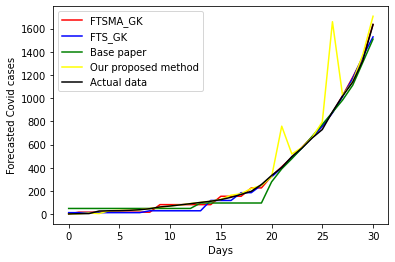

In [ ]:

error = 0 
count = 0
forecast_cum = []

for i in range(0 , 20):
  data = pd.read_csv('./case_time_series.csv')['Total Confirmed'][checkpoints[i][0] : checkpoints[i][1]].tolist()
  FTSModel = FTS(len(data) , data)
  forecast = [FTSModel.predict(i) for i in range(0 , len(data))]
  for f in forecast:
    forecast_cum.append(f)
  error += AFER(data , len(data) , forecast)
  count += 1

print('AFER is {} %'.format(error / count))
print(forecast_cum)
interval_df = FTSModel.intervaldisplay()
fuzzify_df = FTSModel.fuzzify()
compare_results_df = FTSModel.compareResults()



import matplotlib.pyplot as plt

#For the month of March
data = pd.read_csv('./case_time_series.csv')['Total Confirmed'][checkpoints[0][0] : checkpoints[19][1]].tolist()

FTSModel = FTS(len(data) , data)
forecast = [FTSModel.predict(i) for i in range(0 , len(data))]

print('AFER is {}'.format(AFER(data , len(data) , forecast)))

X = np.arange(checkpoints[0][0] , checkpoints[0][1])

ANHFTS = ANHFTS[checkpoints[0][0] : checkpoints[0][1]]
FTSMA_GK = FTSMA_GK[checkpoints[0][0] : checkpoints[0][1]]
FTSMA_CPM = FTSMA_CPM[checkpoints[0][0] : checkpoints[0][1]]
FTS_GK = FTS_GK[checkpoints[0][0] : checkpoints[0][1]]


plt.xlabel('Days')
plt.ylabel('Forecasted Covid cases')
ax = plt.gca()
ax.locator_params('y' , nbins = 10)
plt.plot(X , FTSMA_GK , color = 'red' , label = 'FTSMA_GK')
plt.plot(X , FTS_GK, color = 'blue' , label = 'FTS_GK')
plt.plot(X , ANHFTS, color = 'green' , label = 'Base paper')
plt.plot(X , FTSMA_CPM, color = 'yellow' , label = 'Our proposed method')
plt.plot(X , FTSModel.data[checkpoints[0][0] : checkpoints[0][1]] , color = 'black' , label = 'Actual data')
data = data[checkpoints[0][0] : checkpoints[0][1]]
plt.legend()

plt.show()

**Comparative Analysis**

In [ ]:
result_df = {'Model': [] , 'MSE' : []  , 'RMSE' : [] , 'MAPE/AFER' : [] , 'THEIL-U' : []}
result_df['Model'] = ['ANHFTS' , 'FTS-GK' , 'FTSMA-GK' , 'FTSMA-CPM']
result_df['MSE'] = [MSE(data , len(data) , ANHFTS) , MSE(data , len(data) ,FTS_GK) , MSE(data , len(data) ,FTSMA_GK) , MSE(data , len(data) ,FTSMA_CPM)]
result_df['RMSE'] = [RMSE(data , len(data) ,ANHFTS) , RMSE(data , len(data) ,FTS_GK) , RMSE(data , len(data) ,FTSMA_GK) , RMSE(data , len(data) ,FTSMA_CPM)]
result_df['MAPE/AFER'] = [AFER(data , len(data) ,ANHFTS), AFER(data , len(data) ,FTS_GK) , AFER(data , len(data) ,FTSMA_GK) , AFER(data , len(data) ,FTSMA_CPM)]
result_df['THEIL-U'] = [Theil(data , len(data) ,ANHFTS), Theil(data , len(data) ,FTS_GK) , Theil(data , len(data) ,FTSMA_GK) , Theil(data , len(data) ,FTSMA_CPM)]


result_df['MSE'] = ['{:.7f}'.format(x) for x in result_df['MSE']]
result_df['RMSE'] = ['{:.7f}'.format(x) for x in result_df['RMSE']]
result_df['THEIL-U'] = ['{:.9f}'.format(x) for x in result_df['THEIL-U']]

df = pd.DataFrame(result_df)[['Model' , 'MSE' , 'RMSE' , 'MAPE/AFER', 'THEIL-U']]

display(df)

,Model,MSE,RMSE,MAPE/AFER,THEIL-U
0,ANHFTS,2555.9677419,50.5565796,125.724164,0.004285754
1,FTS-GK,1059.1290323,32.5442627,44.549885,0.001732247
2,FTSMA-GK,339.4516129,18.4242127,29.923573,0.000543003
3,FTSMA-CPM,23977.1612903,154.8456047,14.236874,0.033644552


**Code for conversion to latex table**

In [ ]:
def latex_with_lines(df, *args, **kwargs):
    kwargs['column_format'] = '|'.join([''] + ['l'] * df.index.nlevels
                                            + ['r'] * df.shape[1] + [''])
    res = df.to_latex(*args, **kwargs, index = False)
    return res.replace('\\\\\n', '\\\\ \\midrule\n')

RESULT = latex_with_lines(df)
print(RESULT)

INTERVALS = latex_with_lines(interval_df)
COMPARE = latex_with_lines(fuzzify_df)
COMP = latex_with_lines(compare_results_df)

print(COMPARE)

\begin{tabular}{|l|r|r|r|r|r|}
\toprule
    Model &           MSE &        RMSE &  MAPE/AFER &     THEIL-U \\ \midrule
\midrule
   ANHFTS &  2555.9677419 &  50.5565796 & 125.724164 & 0.004285754 \\ \midrule
   FTS-GK &  1059.1290323 &  32.5442627 &  44.549885 & 0.001732247 \\ \midrule
 FTSMA-GK &   339.4516129 &  18.4242127 &  29.923573 & 0.000543003 \\ \midrule
FTSMA-CPM & 23977.1612903 & 154.8456047 &  14.236874 & 0.033644552 \\ \midrule
\bottomrule
\end{tabular}

\begin{tabular}{|l|r|r|r|r|}
\toprule
 ACTUAL DATA &   GROWTH & FUZZIFIED VALUE &        FLR \\ \midrule
\midrule
    33789197 &        - &               - &          - \\ \midrule
    33812386 & 0.068628 &             A12 &          - \\ \midrule
    33834030 & 0.064012 &             A12 & A12 -> A12 \\ \midrule
    33851131 & 0.050544 &              A9 &  A12 -> A9 \\ \midrule
    33870175 & 0.056258 &             A10 &  A9 -> A10 \\ \midrule
    33892780 &  0.06674 &             A12 & A10 -> A12 \\ \midrule
    33914254 